In [1]:
### Denoising Adverarial Autoencoder (MNIST) : Version 2 : matching q*(z|x) to p(z)
#if n_hidden==2 uses 2D 10-mix gaussian
#if n_hidden==10 uses 10D normal

In [2]:
from lasagne.layers import InputLayer, DenseLayer, Conv2DLayer, Deconv2DLayer, flatten, reshape, batch_norm
from lasagne.nonlinearities import rectify as relu
from lasagne.nonlinearities import LeakyRectify as lrelu
from lasagne.nonlinearities import sigmoid
from lasagne.layers import get_output, get_all_params, get_output_shape
from lasagne.objectives import binary_crossentropy as bce
from lasagne.objectives import squared_error
from lasagne.updates import adam,sgd

import numpy as np
import theano
from theano import tensor as T
import time
from matplotlib import pyplot as plt 
%matplotlib inline

from skimage.io import imsave

import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from sklearn import neighbors

from ll import ll

floatX=theano.config.floatX

Using gpu device 0: GeForce GT 630 (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 4007)


In [3]:
#Options for the network
class options(object):
    def __init__(self):
        self.n_hidden=10   #(10 or 2)
        self.alpha=0.0002  #learning rate
        self.sigma=0.5     #standard deviation of corruption process
        self.batchsize=64  #batch size used for training
        self.epoch=100     #number of traning epochs
        self.upper_bound=0.75 #only train discriminator is the encoder adv loss is less than this upper bound
        self.M=5           #number of monte carlo intergration steps
        
myOpts=options()

In [4]:
##Build the networks
def build_net(opts):
    
    #Encoder: x* --> z
    enc=InputLayer(shape=(None,28*28))
    enc=DenseLayer(incoming=enc, num_units=1000, nonlinearity=relu)
    enc=DenseLayer(incoming=enc, num_units=1000,nonlinearity=relu)
    enc=DenseLayer(incoming=enc, num_units=opts.n_hidden,nonlinearity=lrelu(1))
    
    #Decoder: z --> x
    dec=InputLayer(shape=(None,opts.n_hidden))
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=1000,nonlinearity=relu)
    dec=DenseLayer(incoming=dec, num_units=28*28,nonlinearity=sigmoid)
    
    #Discriminator: x --> real(1) or fake(0)
    dis=InputLayer(shape=(None,opts.n_hidden))
    dis=DenseLayer(incoming=dis, num_units=1000,nonlinearity=relu)
    dis=DenseLayer(incoming=dis, num_units=1000,nonlinearity=relu)
    dis=DenseLayer(incoming=dis, num_units=1,nonlinearity=sigmoid)
    
    return enc, dec, dis
    

In [5]:
##Make the training, encoding and sampling theano functions
def prep_train(opts):
    #sigma = variation of the gaussian noise used to corrupt the input
    enc,dec,dis=build_net(opts)
    
    #Symbolic vars
    x=T.matrix('x') #MNIST are saved as vectors
    z=T.matrix('z')

    #The outputs for training autoencoder:
    rng=T.shared_randomstreams.RandomStreams(np.random.randint(low=1,high=1234))
    corr_x=x+opts.sigma*rng.normal(size=T.shape(x),dtype=floatX) #corrupted x
    enc_x_corr=get_output(enc,corr_x) #enc(x*) encoding corrupted x
    dec_enc_x_corr=get_output(dec,enc_x_corr) #dec(enc(x*)) decoding the encoded input
    
    #The outputs for training encoder w/ discriminative loss
    zi=T.zeros((x.shape[0],opts.n_hidden))
    for i in range(opts.M): #corrupt a single x samples M times and encoder that corrupted sample
        corr_x_i=x+opts.sigma*rng.normal(size=T.shape(x),dtype=floatX) #corrupted x
        zi+=get_output(enc,corr_x_i) #sum z_i's
    z_fake=zi/opts.M #the mean enocoded z
        
    p_fake=get_output(dis,z_fake) #D(enc(x)) is decoded x_corr real or fake? fake
    p_real=get_output(dis,z) #D(z) is z real or fake? real
    
    #The outputs for testing:
    samples=get_output(dec,z,deterministic=True) #generated samples
    encoding=get_output(enc,x,deterministic=True) #encoded samples
    reconstruction=get_output(dec,enc_x_corr,deterministic=True) #reconstructed samples

    #The params
    params_enc=get_all_params(enc)
    params_dec=get_all_params(dec)
    params_dis=get_all_params(dis)

    #The loss
    #The reconstruction loss
    J_rec=bce(dec_enc_x_corr,x).mean()

    #The prior matching loss (adv loss)
    J_adv_dis=bce(p_real, T.ones_like(p_real)).mean()+bce(p_fake, T.zeros_like(p_fake)).mean()
    J_adv_enc=bce(p_fake, T.ones_like(p_fake)).mean()

    #The updates
    update_rec=adam(J_rec, params_enc+params_dec,learning_rate=opts.alpha) #update the encoder and decoder w/ reconstruction loss
    update_dis=adam(J_adv_dis, params_dis,learning_rate=opts.alpha) #update the discriminator w/ adversarial loss
    update_enc=adam(J_adv_enc, params_enc,learning_rate=opts.alpha) #update the encoder w/ adversarial loss

    #The theano training functions
    train_rec=theano.function(inputs=[x],outputs=J_rec, updates=update_rec) #trains encoder and decoder using reconstruction loss
    train_dis=theano.function(inputs=[x,z],outputs=J_adv_dis, updates=update_dis) #trains discriminator using adversarial loss
    train_enc=theano.function(inputs=[x],outputs=J_adv_enc, updates=update_enc) #trains encoder only using adversarial loss
    
    #The theano testing functions
    sample=theano.function(inputs=[z],outputs=samples) #function to sythesise data samples
    encode=theano.function(inputs=[x],outputs=encoding) #function to encoder data samples
    reconstruct=theano.function(inputs=[x], outputs=[squared_error(x,reconstruction),reconstruction]) #corrupted and reconstruct data samples
    
    return train_rec,train_dis,train_enc,  sample,encode,reconstruct, enc,dec,dis
    
    

In [6]:
##Load the training, testing and validation datasets
def load_data():
    train,test,val = np.load('InData/mnist.pkl',mmap_mode='r')
    print 'x_train \t | y_train \t| x_test \t | y_test \t| x_val \t| y_val \n----------------------------------------------------------------------------------------'
    print np.shape(train[0]),'\t',np.shape(train[1]),'\t',np.shape(test[0]),'\t',np.shape(test[1]),'\t',np.shape(val[0]),'\t',np.shape(val[1])
    return train[0], train[1], test[0], test[1], val[0], val[1]

(10000, 10)


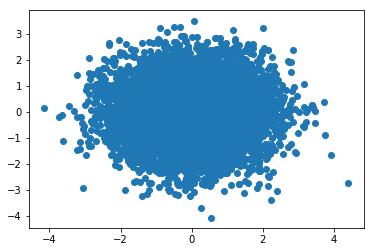

In [7]:
def P_z(size,type=None):
    if size[1] is 2:
        #samples at 2D 10-giassuain mix
        p=np.random.randint(low=0, high=10, size=(size[0],1))
        samples_x=np.zeros((size[0],1))
        samples_y=np.zeros((size[0],1))

        r=4
        theta=np.pi*2/10
        for i in range(10):
            samples_x+=(p==i)*np.random.normal(loc=r*(np.sin(i*theta)+np.cos(i*theta)), scale=0.5, size=(size[0],1))
            samples_y+=(p==i)*np.random.normal(loc=r*(-np.sin(i*theta)+np.cos(i*theta)), scale=0.5, size=(size[0],1))
        return np.hstack([samples_x,samples_y]).astype(floatX)
    else:
        return np.random.normal(size=size).astype(floatX)

#Esamples of samples from the mixutre distribution
Z=P_z(size=(10000,myOpts.n_hidden))
print np.shape(Z)
plt.scatter(Z[:,0],Z[:,1])

In [8]:
##Training function
def train(opts):
    train_rec,train_dis,train_enc,  sample,encode,reconstruct,  enc,dec,dis=prep_train(opts)
    x_train,y_train,x_test,y_test,x_val,y_val=load_data()
    
    batches=int(float(x_train.shape[0])/opts.batchsize)
    
    #Tally of costs
    cost_rec=[] #reconstruction cost of the encoder, decoder net
    cost_dis=[] #aversarial cost on discriminator
    cost_enc=[] #adversarial cost on encoding
    
    print 'epoch   batch   cost_dis   cost_enc   cost_rec   time '
    for e in range(opts.epoch):
        timer = time.time()
        for b in range(batches):
            #Z = np.random.normal(size=(opts.batchsize,opts.n_hidden)).astype(floatX)
            Z=P_z(size=(opts.batchsize,opts.n_hidden))
            X=x_train[b*opts.batchsize:(1+b)*opts.batchsize]
            #train the discriminator
            cost_dis.append(train_dis(X,Z))
            #train the encoder (w/ adversarial) 
            cost_enc.append(train_enc(X))
            #train the autoencer (enc and dec) (w/ reconstruction loss)
            cost_rec.append(train_rec(X))
            
        print "%d \t %d  \t %.3f \t %.3f \t %.3f \t %.2f" % (e,b,cost_dis[-1],cost_enc[-1],cost_rec[-1], time.time()-timer)
    
    return sample,encode,reconstruct,cost_enc,cost_rec,cost_dis
    

In [ ]:
##Training 
sample,encode,reconstruct,cost_enc,cost_rec,cost_dis=train(myOpts)

In [ ]:
#Save all models:
import pickle
dir='DAAE_v2_params'
pickle.dump(sample,open(dir+'/sample.pkl','w'))
pickle.dump(encode,open(dir+'/encode.pkl','w'))
pickle.dump(reconstruct,open(dir+'/reconstruct.pkl','w'))
pickle.dump(myOpts,open(dir+'/myOpts.pkl','w'))
np.save(dir+'/cost_enc.npy',cost_enc)
np.save(dir+'/cost_rec.npy',cost_rec)
np.save(dir+'/cost_dis.npy',cost_dis)

In [11]:
#load all models:
import pickle
dir='DAAE_v2_params'
# dir='../../Expeirments/DAAE_v2/DAAE_v2_1_a/models_DAAE_v2_1_a/'
sample=pickle.load(open(dir+'/sample.pkl','r'))
encode=pickle.load(open(dir+'/encode.pkl','r'))
reconstruct=pickle.load(open(dir+'/reconstruct.pkl','r'))
myOpts=pickle.load(open(dir+'/myOpts.pkl','r'))
cost_enc=np.load(dir+'/cost_enc.npy')
cost_rec=np.load(dir+'/cost_rec.npy')
cost_dis=np.load(dir+'/cost_dis.npy')

print 'sigma:',myOpts.sigma,', n_hidden',myOpts.n_hidden, ', M', myOpts.M

sigma: 0.5 , n_hidden 10 , M 5


x_train 	 | y_train 	| x_test 	 | y_test 	| x_val 	| y_val 
----------------------------------------------------------------------------------------
(50000, 784) 	(50000,) 	(10000, 784) 	(10000,) 	(10000, 784) 	(10000,)


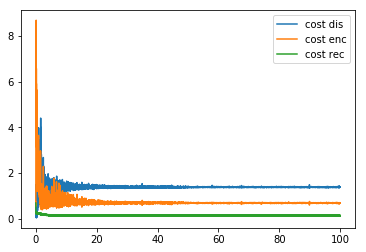

In [12]:
##Training Plots
#Cost plots
x_train,y_train,x_test,y_test,x_val,y_val=load_data()
step=1./int(float(x_train.shape[0])/myOpts.batchsize)
y=np.arange(0,myOpts.epoch,step)
plt.plot(y,cost_dis,label='cost dis')
plt.plot(y,cost_enc,label='cost enc')
plt.plot(y,cost_rec,label='cost rec')
plt.legend()

mean squared error loss: 0.0217232 +/- 0.000768017321825


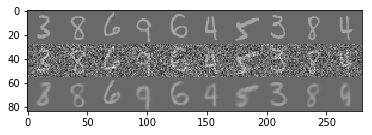

In [13]:
#Apply reconstruction to all the test images
x_rec_loss,x_rec=reconstruct(x_test)
print "mean squared error loss:", np.mean(x_rec_loss), "+/-", np.std(x_rec_loss)/np.sqrt(x_rec_loss.shape[0])
egs=10 #no of random examples to show
x_noise=(x_test[:egs]+np.random.normal(loc=0.0, scale=myOpts.sigma, size=(egs,28*28))).reshape(egs,28,28)
plt.imshow(np.hstack(np.hstack(([x_test[:egs].reshape(egs,28,28),x_noise,x_rec[:egs].reshape(egs,28,28)]))),cmap='gray')
plt.figure()

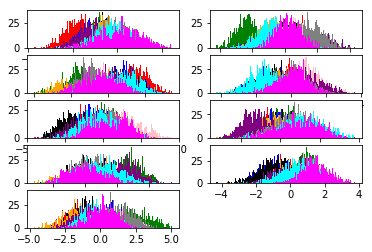

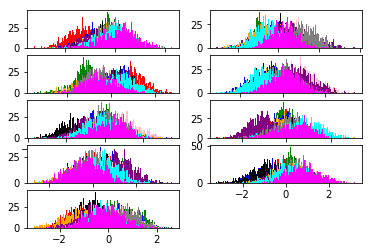

In [14]:
##Encodings (look at both p(z|x*) and p*(z|x)) - demonstarte the p*(z|x) has fit while p(z|x*) has not)
colours=['red','green','blue','black','pink','orange','purple','gray','cyan','magenta']
#Encode: z ~ p(z|x*)
x_enc=encode(x_test)
#Look at histrograms of encodings (For 10D Gaussian)
plt.figure(1)
if myOpts.n_hidden==10:
    for i in range(9):
        n=520+i+1
        plt.subplot(n)
        for j in range(10):
            plt.hist(x_enc[np.argwhere(y_test==j),i],100, color=colours[j])
if myOpts.n_hidden==2:
    plt.scatter(x_enc[:,0],x_enc[:,1])
    
#Encode: z ~ p*(z|x)
plt.figure(2)
z_i=0
for i in range(myOpts.M):
    x_corr_i= x_test + np.random.normal(loc=0.0, scale=myOpts.sigma, size=np.shape(x_test))
    z_i+=encode(x_corr_i.astype(floatX))
z_mean=z_i/myOpts.M

if myOpts.n_hidden==10:
    for i in range(9):
        n=520+i+1
        plt.subplot(n)
        for j in range(10):
            plt.hist(z_mean[np.argwhere(y_test==j),i],100, color=colours[j])
if myOpts.n_hidden==2:
    plt.scatter(z_mean[:,0],z_mean[:,1])

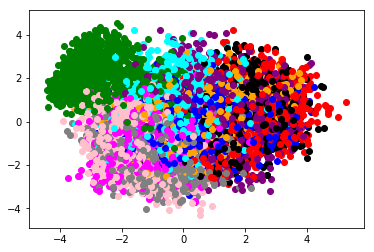

In [15]:
##Show the latent space
colours=['red','green','blue','black','pink','orange','purple','gray','cyan','magenta']
for i in range(x_test.shape[0]):
    try: #n_hidden=10 (>2)
        reduced_x_enc=PCA(n_components=2).fit_transform(x_enc)
        plt.scatter(reduced_x_enc[i,0],reduced_x_enc[i,1], color=colours[y_test[i]])
    except: #n_hidden=2
        plt.figure(211)
        plt.scatter(encode(x_train)[i,0],encode(x_train)[i,1], color=colours[y_train[i]])
        plt.title('Training data')
        plt.figure(212)
        plt.scatter(x_enc[i,0], x_enc[i,1],color=colours[y_test[i]])
        plt.title('Testing data')

In [16]:
##Classification
#Train a linear SVM on the features from x_train
enc_train=encode(x_train)
enc_test=encode(x_test)
classifier=SVC().fit(enc_train,y_train) #default rbf kernel
score=classifier.score(enc_test,y_test)
print "mean accuracy (SVM):",score*100,'%'

mean accuracy (SVM): 96.48 %


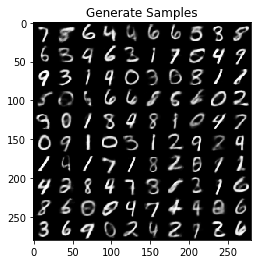

In [17]:
##Samples:
#Draw from the prior and sample (random)
row=col=10
noSamples=row*col
Z=np.random.normal(loc=0.0, scale=1.0, size=(noSamples,myOpts.n_hidden)).astype(floatX)
x_samples=sample(Z).reshape(noSamples,28,28)
#display as montage
montage=np.zeros((row*28,col*28))
n=0
for r in range(row):
    for c in range(col):
        montage[r*28:(r+1)*28,c*28:(c+1)*28]=x_samples[n]; n+=1;
plt.imshow(montage,cmap='gray')
plt.title('Generate Samples')

In [18]:
##Likelihood analysis
noSamples=10**4
Z=P_z(size=(noSamples,myOpts.n_hidden))
x_sample=sample(Z)
ll,sigma=ll(x_sample, x_val, x_test)
print "by cross validation sigma*=", sigma
print 'log likelihood of x_test under P(x_fake)=',ll

0.1 474.576132137
0.129154966501 532.134085156
0.16681005372 466.976415747
0.215443469003 347.842176615
0.278255940221 192.675056988
0.35938136638 20.6388352365
0.464158883361 -163.484550945
0.599484250319 -353.022033511
0.774263682681 -544.844592179
1.0 -738.525364437
by cross validation sigma*= 0.129154966501
log likelihood of x_test under P(x_fake)= 533.090363047


In [ ]:
exit()